# **APS1080: Introduction to Reinforcement Learning**
---



---





---
**Exercise V:** Policy Gradient

------

Utilize the REINFORCE algorithm of c13 to sole the cart-pole environment.



This is an exercise, however, I highly recommend it be done with the diligence of an assignment to ensure you're prepared for the test.

----

## **A. Prelims**

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install xvfb

In [2]:
import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict


import numpy as np
import tensorflow as tf
import random
from collections import deque

import keras

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [5]:
def round_state(state):
    state[0] = round(state[0], 1)
    state[1] = round(state[1], 2)
    return state
'''

Using v1 because of the warning (UserWarning: WARN: The environment
CartPole-v0 is out of date. You should consider upgrading to version `v1`.)

'''

env = gym.make("CartPole-v1")
actionSpaceSize = env.action_space.n

Iterations that were run: 11


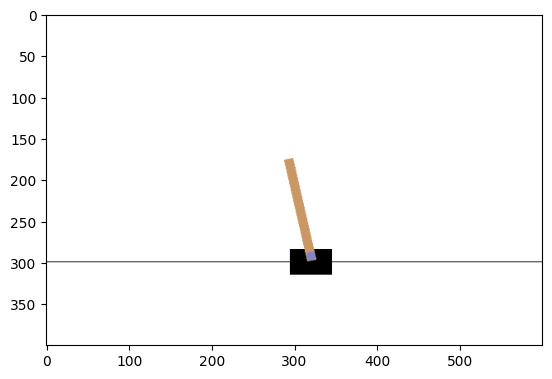

In [6]:
env = gym.make("CartPole-v1")

# Reset the environment to its initial state
env.reset()

# Render the initial frame as an RGB array
prev_screen = env.render(mode='rgb_array')

actionSpaceSize = env.action_space.n

plt.imshow(prev_screen)  # Display the initial frame

# Run a random policy for a maximum of 100 steps
for i in range(100):
    action = env.action_space.sample()  # Sample a random action from the action space
    print("step i", i, "action=", action)  # Print the current step and chosen action
    obs, reward, done, info = env.step(action)  # Apply the action to the environment and get the results
    print("obs=", obs, "reward=", reward, "done=", done, "info=", info)  # Print the observation, reward, done flag, and info

    screen = env.render(mode='rgb_array')  # Render the current frame as an RGB array
    plt.imshow(screen)  # Display the current frame
    ipythondisplay.clear_output(wait=True)  # Clear the current display
    ipythondisplay.display(plt.gcf())  # Display the updated frame

    if done:  # Check if the episode is finished
        break  # Exit the loop if the episode is finished

# Clear the final display and close the environment
ipythondisplay.clear_output(wait=True)
env.close()  # Close the environment
print("Iterations that were run:", i)  # Print the number of iterations that were run



----
## **B. Construct a neural network as a policy network**

In [7]:
class PolicyNetwork(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units=24):
        super(PolicyNetwork, self).__init__()
        self.hidden1 = layers.Dense(hidden_units, activation='relu')
        self.hidden2 = layers.Dense(hidden_units, activation='relu')
        self.output_layer = layers.Dense(output_dim, activation='softmax')

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        output = self.output_layer(x)
        return output

# usage for the CartPole environment:
input_dim = 4  # CartPole state dimension
output_dim = 2  # CartPole action space dimension

policy_network = PolicyNetwork(input_dim, output_dim)
policy_network.build(input_shape=(None, input_dim))
policy_network.summary()


Model: "policy_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  120       
                                                                 
 dense_1 (Dense)             multiple                  600       
                                                                 
 dense_2 (Dense)             multiple                  50        
                                                                 
Total params: 770 (3.01 KB)
Trainable params: 770 (3.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


-----
# **C. Training:**

## **Following REINFORCE Algorithm from CHAPTER 13 of the textbook**

*Utilize the REINFORCE algorithm of c13 to sole the cart-pole environment.*


In [25]:
# Hyperparameters
input_dim = 4  # State space size for CartPole
num_actions = 2  # Action space size for CartPole
hidden_units = 64  # Number of units in hidden layer
learning_rate = 0.001  # Learning rate for the optimizer
gamma = 0.99  # Discount factor for rewards
num_episodes = 1000  # Number of episodes to train

# Create the environment
env = gym.make("CartPole-v1")

# Create the policy network and optimizer
policy_network = PolicyNetwork(input_dim, num_actions, hidden_units)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)  # Initialize array for discounted rewards
    cumulative = 0  # Initialize cumulative reward
    # Compute discounted rewards for each time step
    for t in reversed(range(len(rewards))):
        cumulative = cumulative * gamma + rewards[t]
        discounted_rewards[t] = cumulative
    return discounted_rewards

# Lists to save rewards for plotting
episode_rewards = []  # List to store total rewards for each episode

# Training loop
for episode in range(num_episodes+1):
    state = env.reset()  # Reset the environment
    states, actions, rewards = [], [], []  # Lists to store states, actions, and rewards
    done = False
    episode_reward = 0  # Initialize reward for the current episode

    # Generate an episode
    while not done:
        state = np.expand_dims(state, axis=0).astype(np.float32)  # Add batch dimension and convert to float32
        action_probs = policy_network(state)  # Get action probabilities from the policy network
        action = np.random.choice(num_actions, p=np.squeeze(action_probs))  # Sample action from probabilities

        next_state, reward, done, _ = env.step(action)  # Take action and get next state, reward, and done flag
        states.append(state)  # Store state
        actions.append(action)  # Store action
        rewards.append(reward)  # Store reward
        episode_reward += reward  # Accumulate reward

        state = next_state  # Update state

    # Save the total reward for this episode
    episode_rewards.append(episode_reward)

    # Record reward every 100th episode
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {episode_reward}, Loss: {loss.numpy()}")

    # Compute returns
    discounted_rewards = compute_discounted_rewards(rewards, gamma)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)

    # Convert states and actions to tensors
    states = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)

    with tf.GradientTape() as tape:
        # Compute action probabilities
        action_probs = policy_network(states)
        action_probs = tf.gather_nd(action_probs, tf.stack([tf.range(len(actions)), actions], axis=1))

        # Compute loss
        loss = -tf.reduce_mean(tf.math.log(action_probs) * discounted_rewards)

    # Update the policy network
    grads = tape.gradient(loss, policy_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, policy_network.trainable_variables))

# ----------------------------------------------------------------------



Episode 0, Total Reward: 71.0, Loss: 24.544933319091797
Episode 100, Total Reward: 38.0, Loss: 12.15369987487793
Episode 200, Total Reward: 44.0, Loss: 24.567594528198242
Episode 300, Total Reward: 67.0, Loss: 19.429094314575195
Episode 400, Total Reward: 47.0, Loss: 16.458251953125
Episode 500, Total Reward: 63.0, Loss: 8.885754585266113
Episode 600, Total Reward: 201.0, Loss: 38.737972259521484
Episode 700, Total Reward: 203.0, Loss: 40.76884078979492
Episode 800, Total Reward: 114.0, Loss: 20.59014892578125
Episode 900, Total Reward: 167.0, Loss: 47.11738586425781
Episode 1000, Total Reward: 141.0, Loss: 23.398948669433594


-----------------
# **D. Plots**

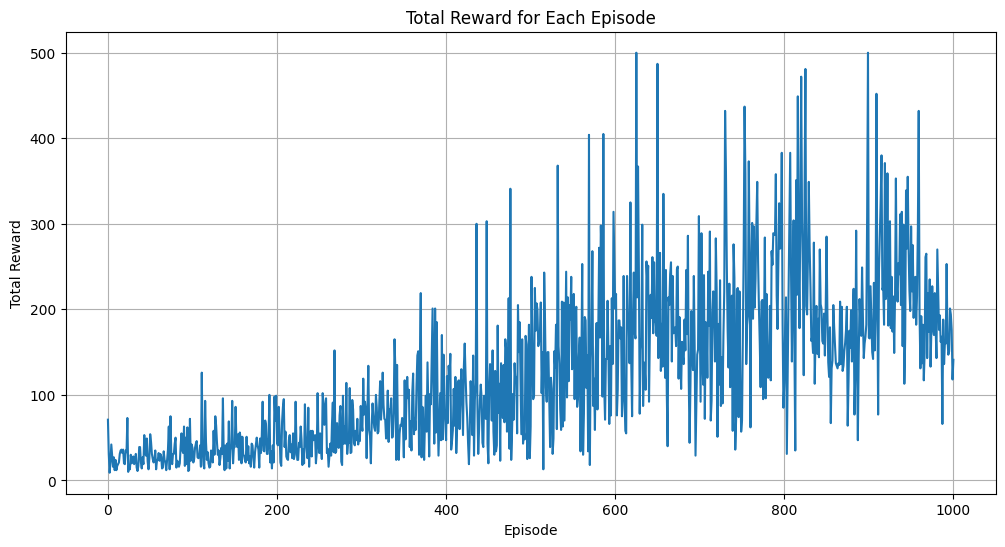

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward for Each Episode')
plt.grid(True)
plt.show()


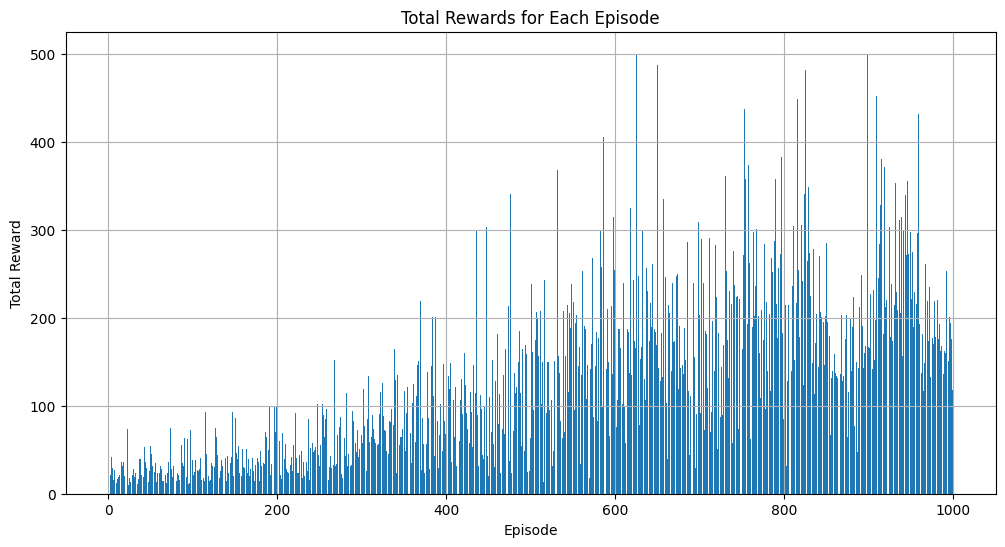

In [27]:
plt.figure(figsize=(12, 6))
plt.bar(range(num_episodes+1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards for Each Episode')
plt.grid(True)
plt.show()


-------------------
# **E. Implementation and Analysis**

In this implementation of the REINFORCE algorithm for solving the CartPole environment, we used a policy network to approximate the optimal policy.

**Model Architecture**:

- Input Dimension: 4 (corresponding to the state space of CartPole)
- Hidden Layer: 64 units with ReLU activation function
- Output Layer: 2 units with a softmax activation function to represent action probabilities

**Hyperparameters**:

- Learning Rate: 0.001 (determined to be the most effective from experimentation)
- Discount Factor (γ): 0.99, which determines the importance of future rewards
- Number of Episodes: 1000 episodes for training

**Training Process**
- We computed the discounted rewards to provide a measure of future rewards' impact and used this to train the network.
- The policy network was updated based on the computed gradients of the loss function, which is derived from the log probability of actions taken and the corresponding discounted rewards.

**Results and Conclusions**
- Initial Performance: In the early episodes, such as episode 0, the model achieved a relatively high reward of 71. However, this high reward can be attributed to randomness rather than learned behavior.

- Training Dynamics: We observed a decrease in reward to 38 by episode 100, suggesting that the model was exploring different policies and adjusting its learning. This fluctuation is common as the model transitions from exploration to exploitation.

- Improved Performance: By episode 600, the total reward improved significantly to 201, indicating that the policy network started to learn effective strategies for balancing the pole. This improvement demonstrates that the model is successfully optimizing the policy over time.

- Convergence: By episode 1000, the total reward stabilized around 141. This stabilization suggests that the policy network has converged to a reasonably effective strategy for the CartPole task, although there is still room for improvement.

- Loss Fluctuations: The loss values fluctuated throughout training, which is expected due to the high variance inherent in policy gradient methods. Despite these fluctuations, the trend shows that the policy is becoming more stable and effective over time.